# Cell segmentation and quantification  
We will use here cellpose for cell segmentation:

Stringer, C., Wang, T., Michaelos, M., & Pachitariu, M. (2021). Cellpose: a 
generalist algorithm for cellular segmentation. Nature methods, 18(1), 100-106. 

To install cellpose, type in a terminal with the environment activated:


In [ ]:
!pip install cellpose

In [73]:
# Run this cell is your are developing the code locally
%load_ext autoreload
%autoreload 2
import sys
import site
site.addsitedir('../') 

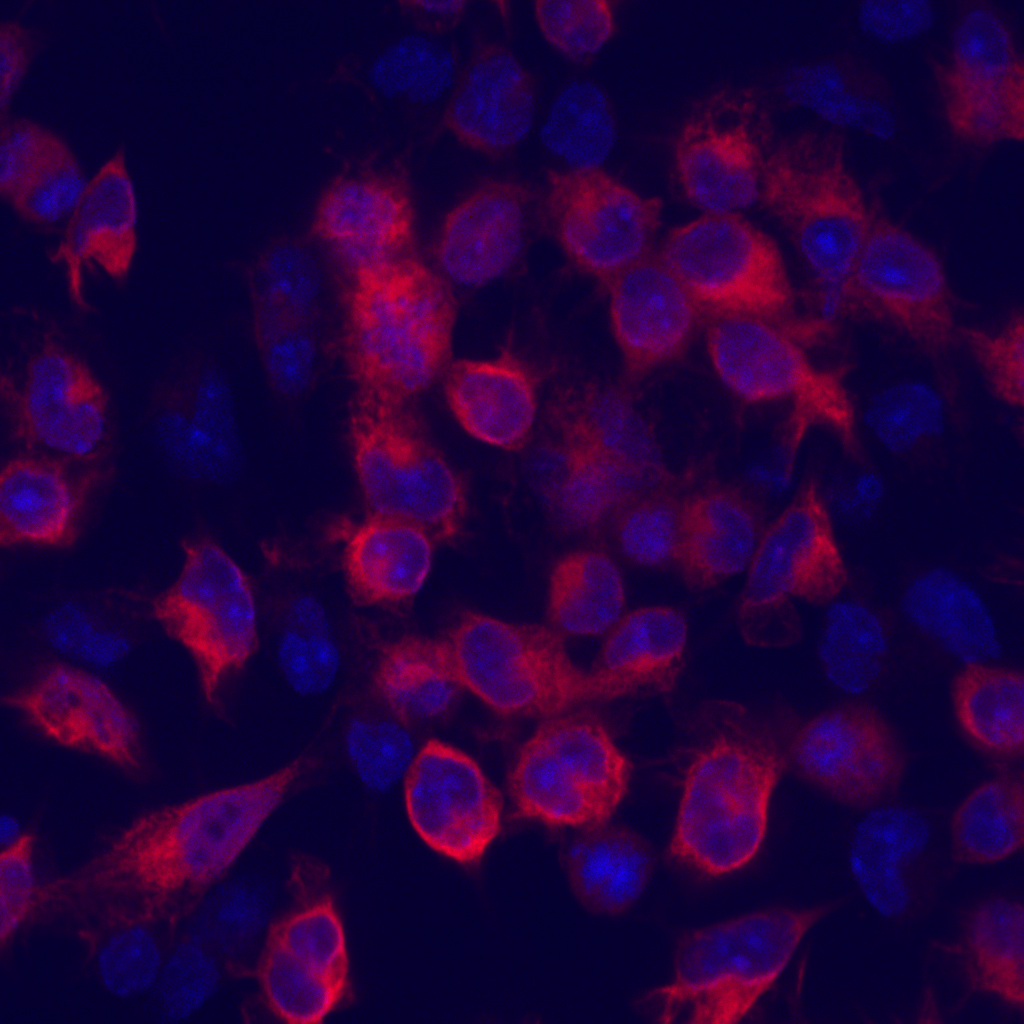

In [162]:
from mug import utils
import nd2

filename = '/media/micro-nas-1/Kozik_lab/Marco/Images for Jerome/20230109 images/B1_1.nd2'

img = nd2.imread(filename)
nuclei_channel = 7
cell_channel = 2
signal_channel = 0
img = img[:,0:1024,0:1024]
utils.to_pil(img[[cell_channel,nuclei_channel]],['red','blue'])

In [1]:
from cellpose import models, core # cell segmentation
print(core.use_gpu())
model = models.Cellpose(gpu=core.use_gpu(), model_type='cyto2')
mask, flows, styles, diams = model.eval(img[[cell_channel,nuclei_channel],:,:], diameter=100, flow_threshold=None, channels=[0,1])

/home/jeromeb/miniconda3/envs/imaging/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'img' is not defined

TypeError: Image data of dtype object cannot be converted to float

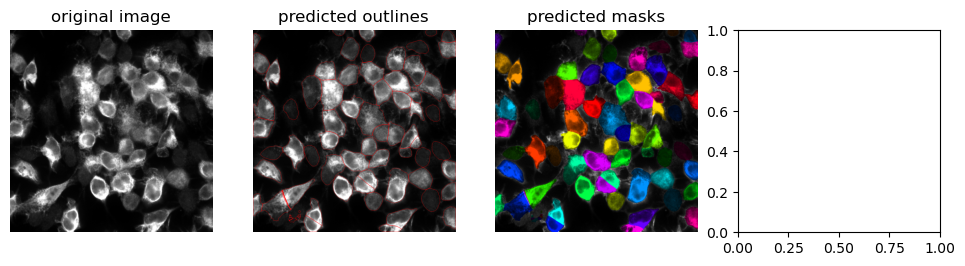

In [181]:
from cellpose import plot
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img[[cell_channel,nuclei_channel],:,:], mask, flows, channels=[0,1])


We can represent the segmentation using regionprops and find_contours

(-0.5, 1023.5, 1023.5, -0.5)

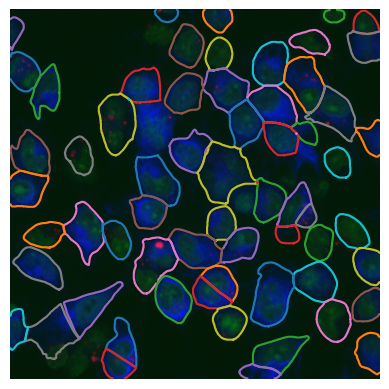

In [182]:
from skimage.measure import regionprops, find_contours
# measure in regions defined by the mask
props = regionprops(mask,img[signal_channel])
# filter out small regions
props = [p for p in props if p.area > 500]
# display segmentation as outlines
plt.imshow(utils.to_pil(img[[signal_channel, cell_channel, nuclei_channel],:,:],['red','blue','green']))
for p in props:
    c = find_contours(mask==p.label,0.5)
    plt.plot(c[0][:,1],c[0][:,0])
plt.axis('off')

Let's now extract some relevant measurements from the regionsprops list:

In [ ]:
tbl = pd.DataFrame({
    'Area [px]': [m.area for m in props],
    'Mean Intenisty': [m.intensity_mean for m in props]
})
tbl

In [ ]:


from PIL import Image
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def normalize_contrast(array:np.ndarray):
    amin = array.max()
    amax = array.min()
    if amax != amin:
        return (array - amin) / (amax - amin)
    else:
        return array

def to_pil(array:np.ndarray, cmap=None) -> Image:
    if len(array.shape) == 2:  
        img = cmap(normalize_contrast(array))        
    else:
        img = sum([
            f(normalize_contrast(x)) for x,f in zip(array, cmap)
        ])
    return Image.fromarray((255*img).astype(np.uint8))



a = sum(np.meshgrid(np.linspace(0,255,255),np.linspace(0,255,255)))
a = a / a.max()
x = np.stack([a,1-a])

cm  = [plt.get_cmap('Greens'), plt.get_cmap('Reds')]
utils.to_pil(x,cm)


#plt.imshow(rgb)



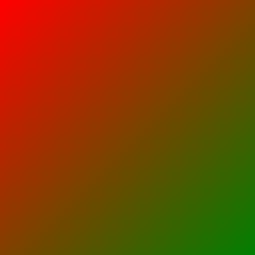

In [71]:
r = LinearSegmentedColormap.from_list('red', ['black','red'])
g = LinearSegmentedColormap.from_list('green', ['black','green'])
b = LinearSegmentedColormap.from_list('blue', ['black','blue'])
to_pil(x,[r,g])

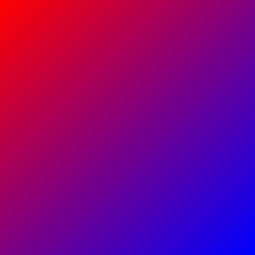

In [107]:
from mug import utils
a = sum(np.meshgrid(np.linspace(0,255,255),np.linspace(0,255,255)))
x = np.stack([a,a.max()-a])
utils.to_pil(x,['red', 'blue'])